In [ ]:
from enum import Enum
from termcolor import colored
import os, pathlib, shutil, random

from matplotlib import pyplot as plt
import numpy
import json 
from json import JSONEncoder, JSONDecoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
vocab_size = 20000
max_tokens = vocab_size
embed_dim = 256
num_heads = 2
dense_dim = 32
sequence_length = 600
batch_size=128

BatchNormalization doesn’t work well for sequence data. Instead, we’re using the LayerNormalization layer, which normalizes each sequence independently from other sequences in the batch. Like this, in NumPy-like pseudocode:

```
def layer_normalization(batch_of_sequences):
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1
    return (batch_of_sequences - mean) / variance
```


```
def batch_normalization(batch_of_images):
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))
    variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2))
    return (batch_of_images - mean) / variance
```

While BatchNormalization collects information from many samples to obtain accurate statistics for the features means and variances, LayerNormalization only pools data within each sequence separately, which is more appropriate for sequence data



In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**Using positional encoding to reinject order information**

> The idea behind positional encoding is very simple: to give the model access to word order information, we’re going to add to each word embedding the word’s position in the sentence. Our input word embeddings will have two components: the usual word vector, which represents the word independently of any specific context, and a position vector, which represents the position of the word in the current sentence. Hopefully, the model will then figure out how to best leverage this additional information.





> The simplest scheme you could come up with would be to concatenate the word’s position to its embedding vector. You’d add a "position" axis to the vector, and fill it with 0 for the first word in the sequence, 1 for the second one, and so on.

> That may not be ideal, however, because your positions can potentially be very large integers, which will disrupt the range of values in the embedding vector. As you know, neural networks don’t like very large input values, or discrete input distributions.

> The original "Attention is all you need paper" used an interesting trick to encode word positions: it added to the word embeddings a vector containing values in the range [-1, 1] that varied cyclically depending on the position (it used cosine functions to achieve this). This trick offers a way to uniquely characterize any integer in a large range via of vector of small values. It’s clever, but it’s not what we’re going to use in our case. We’ll do something simpler and more effective: we’ll just learn position embedding vectors, just the same way we learn to embed word indices. We’ll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. This technique is called "positional embedding". Let’s implement it:

In [ ]:
class Text_Vectorization(Enum):
    def unigram_int():
        return TextVectorization(
            max_tokens=max_tokens,
            output_mode="int",
            output_sequence_length=sequence_length,
        )
    
DATA = {
        'unigram_int': Text_Vectorization.unigram_int()
    }
    
class TransformerSetting:
    def __init__(self,
                 text_vectorization: str,
                 num_heads: int,
                 dense_dim: int,
                 sequence_length: int,
                 input_dim = 20000, 
                 output_dim = 256,
                 is_using_positional_embedding: bool = False,
                 is_using_positional_encoding: bool = False,  
                ):
      self.text_vectorization = text_vectorization
      self.num_heads = num_heads
      self.dense_dim = dense_dim
      self.sequence_length  = sequence_length 
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.is_using_positional_embedding = is_using_positional_embedding
      self.is_using_positional_encoding = is_using_positional_encoding
          
  
    def text_vectorization_func(self):
      return DATA[self.text_vectorization]
    
    def name(self):
        model_name = ""
        if self.text_vectorization is not None:
          model_name += f"{self.text_vectorization}_"
        else:
            raise ValueError("text_vectorization_name musst be specified...")
        model_name+= f"dense_dim_{self.dense_dim}_"
        model_name+= f"num_heads_{self.num_heads}_"
        if sequence_length is not None:
          model_name += f"sequence_length_{sequence_length}_" 
        model_name+= f"input_dim_{self.input_dim}_"
        model_name+= f"output_dim_{self.output_dim}_"
        if self.is_using_positional_embedding:
          model_name += "using_positional_embedding_"
        if self.is_using_positional_encoding:
          model_name += "using_positional_encoding_"
        model_name+= "transformer_model"
       
        return model_name
class TransformerSettingEncoder(JSONEncoder):
        def default(self, o):
            return o.__dict__
        

def decode_transformer_setting(dct):
    return TransformerSetting(
        text_vectorization = dct["text_vectorization"],
        num_heads = dct["num_heads"],
        dense_dim = dct["dense_dim"],
        input_dim = dct["input_dim"],
        output_dim = dct["output_dim"],
        sequence_length  = dct["sequence_length" ],
        is_using_positional_embedding = dct["is_using_positional_embedding"],
        is_using_positional_encoding = dct["is_using_positional_encoding"])

In [ ]:
class IMDB_REVIEWING_ANALYSIS_WORD_AS_SEQUENCE:
    
    def __init__(self, setting: TransformerSetting):
        self.setting = setting
        self.load_datasets()
        self.build_validation_directory_and_fill_it()
        self.text_vectorization = self.setting.text_vectorization_func()
        self.prepaire_datasets()
        self.model = self.build_model(setting)

    def load_datasets(self):
        if not os.path.exists('aclImdb'):
          if not os.path.exists('aclImdb_v1.tar.gz'):
            !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
          !tar -xf aclImdb_v1.tar.gz
          !rm -r aclImdb/train/unsup
        
    
    def build_validation_directory_and_fill_it(self):
        base_dir = pathlib.Path("aclImdb")
        val_dir = base_dir / "val"
        train_dir = base_dir / "train"

        if not os.path.exists(val_dir):

            for category in ("neg", "pos"):

                path = val_dir / category
                if not os.path.exists(path):
                    os.makedirs(path)

                files = os.listdir(train_dir / category)
                random.Random(1337).shuffle(files)
                num_val_samples = int(0.2 * len(files))
                val_files = files[-num_val_samples:]

                for fname in val_files:
                  #src = train_dir / category / fname
                  #dst = val_dir / category / fname
                  src = '/content/aclImdb/train/'+category+'/'+fname
                  dst =  '/content/aclImdb/val/'+category+'/'
                  %mv {src} {dst}

    def prepaire_datasets(self):
        train_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/train", batch_size=batch_size
        )
        val_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/val", batch_size=batch_size
        )
        test_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/test", batch_size=batch_size
        )
        
        text_only_train_ds = train_ds.map(lambda x, y: x)
        self.text_vectorization.adapt(text_only_train_ds)
        
        self.prepaired_train_ds = train_ds.map(lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_val_ds = val_ds.map(lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_test_ds = test_ds.map(lambda x, y: (self.text_vectorization(x), y))     
        
    
    def set_callbacks(self, callbacks):
        self.callbacks = callbacks
    
    def train_model(self, epochs):
        self.history = self.model.fit(
            self.prepaired_train_ds.cache(),
            validation_data= self.prepaired_val_ds.cache(),
            epochs=epochs,
            callbacks=self.callbacks)
    
    def plot_training_curve(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('using_positional_embedding')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    
    def load_model(self, model_name):
        self.model = keras.models.load_model(model_name)
    
    def save_training_curve(self, name):
        pass
    
    def get_test_accuracy(self):
        print(f"Test acc: {self.model.evaluate(self.prepaired_test_ds)[1]:.3f}")
    
    def forward(self, text: str):
        inputs = keras.Input(shape=(1,), dtype="string")
        processed_inputs = self.text_vectorization(inputs)
        outputs = self.model(processed_inputs)
        inference_model = keras.Model(inputs, outputs)
        prepaired_text =  tf.convert_to_tensor([[text],])
        return inference_model(prepaired_text)
    
    def build_model(self, model_setting: TransformerSetting):

        inputs = keras.Input(shape=(None,), dtype="int64")
        
        if self.setting.is_using_positional_embedding:
          x = PositionalEmbedding(self.setting.sequence_length, self.setting.input_dim, self.setting.output_dim)(inputs)
        elif self.setting.is_using_positional_encoding:
          pass
        else:
          x = layers.Embedding(self.setting.input_dim, self.setting.output_dim)(inputs)
        x = TransformerEncoder(self.setting.output_dim, self.setting.dense_dim, self.setting.num_heads)(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(0.5)(x)

        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)
        model.compile(optimizer="rmsprop",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
        return model

In [ ]:
#with open('settings.json', 'w') as f:
#    json.dump(settings, f, indent=4, cls=SettingEncoder)
with open("transformer_settings.json") as settings_data:
    data = settings_data.read()
    settings = json.loads(data, object_hook=decode_transformer_setting)

In [ ]:
models = []
for setting in settings:
    callbacks = [keras.callbacks.ModelCheckpoint(f"{setting.name()}.keras", save_best_only=True )]
    model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SEQUENCE(setting)
    model.set_callbacks(callbacks)
    models.append(model)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Epoch 1/20
157/157 [==============================] - 50s 307ms/step - loss: 0.6580 - accuracy: 0.6852 - val_loss: 0.4054 - val_accuracy: 0.7954
Epoch 2/20
157/157 [==============================] - 42s 269ms/step - loss: 0.2964 - accuracy: 0.8761 - val_loss: 0.3645 - val_accuracy: 0.8510
Epoch 3/20
157/157 [==============================] - 42s 269ms/step - loss: 0.1970 - accuracy: 0.9226 - val_loss: 0.3115 - val_accuracy: 0.8924
Epoch 4/20
157/157 [==============================] - 42s 269ms/step - loss: 0.1292 - accuracy: 0.9506 - val_loss: 0.3826 - val_accuracy: 0.8878
Epoch 5/20
157/157 [==============================] - 42s 268ms/step - loss: 0.0892 - accuracy: 0.9650 - val_loss: 0.4982 - val_accuracy: 0.8762
Epoch 6/20
157/157 [==============================] - 42s 268ms/step - loss: 0.0597 - accuracy: 0.9762 - val_loss: 0.5241 - val_accuracy: 0.8840
Epoch 7/20
157/157 [==============================] - 42s 269ms/step - loss: 0.0448 - accuracy: 0.9823 - val_loss: 0.5287 - val_ac

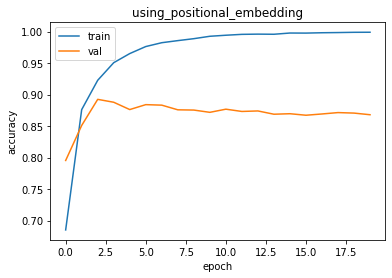

196/196 [==============================] - 23s 118ms/step - loss: 1.5310 - accuracy: 0.8293
Test acc: 0.829


In [ ]:
for model in models:
    model.train_model(20)
for model in models:
    model.plot_training_curve()
for model in models:
    model.get_test_accuracy()  

In [ ]:
for model in models:
    model.get_test_accuracy()  

196/196 [==============================] - 23s 117ms/step - loss: 1.5310 - accuracy: 0.8293
Test acc: 0.829


In [ ]:
models_with_model_name = {}
for model in models:
    models_with_model_name['using_positional_embedding'] = model


In [ ]:
positive_text = "That was an excellent movie, I loved it."
negative_text = "That was a bad movie, I hated it."
middle1_text = "That was a bad movie, I loved it."
middle2_text = "That was an excellent movie, I hated it."
minh_text = "I hated it. That was a sad movie."

sentences = [positive_text, negative_text, middle1_text, middle2_text, minh_text]

In [ ]:
def convert_to_tensor(text):
    return tf.convert_to_tensor([[text],])

In [ ]:
def predict_models(models, text, is_in_tensor: bool):
    print(colored(text, 'green'))
    for items in models.items():
        model_name = items[0]
        model = items[1]
        if not is_in_tensor:
            predictions = model.forward(convert_to_tensor(text))
        else: 
            predictions = model.forward(text)
        
        print(f"{model_name}: ", colored(f"{float(predictions[0] * 100):.2f}", 'red') + " percent positive" )

In [ ]:
for sentence in sentences:
    predict_models(models_with_model_name, sentence, True)
    print("- - - - - - - -  - - - - - - - - - ")

That was an excellent movie, I loved it.
using_positional_embedding:  6.72 percent positive
- - - - - - - -  - - - - - - - - - 
That was a bad movie, I hated it.
using_positional_embedding:  0.00 percent positive
- - - - - - - -  - - - - - - - - - 
That was a bad movie, I loved it.
using_positional_embedding:  0.24 percent positive
- - - - - - - -  - - - - - - - - - 
That was an excellent movie, I hated it.
using_positional_embedding:  2.94 percent positive
- - - - - - - -  - - - - - - - - - 
I hated it. That was a sad movie.
using_positional_embedding:  0.00 percent positive
- - - - - - - -  - - - - - - - - - 
